In [1]:
import time
import sys, os
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt
import anndata

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-5', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'baseline_tmp.cpt',
                               '--exp-name', 'baseline_dentategyrus',
                               '--device', 'cuda:0',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "X",
                              ])


In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("OPC", "OL")]
k_cluster = "clusters"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay, save_name="tmp.cpt"):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr = args.lr  
    i, losses = 0, [sys.maxsize]  
    min_loss = losses[-1]
    model_saved = False

    model.train()
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_s, tensor_u], model, optimizer, xyids=[0, 1], device=device)
        losses.append(loss)
        if i % args.log_interval == 0:
            if losses[-1] < min_loss:
                min_loss = losses[-1]
                torch.save(model.state_dict(), os.path.join(args.output, save_name))
                model_saved = True
            else:
                if model_saved:
                    model.load_state_dict(torch.load(os.path.join(args.output, save_name)))
                    model = model.to(device)
                lr *= args.lr_decay
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

            print("Train Epoch: {:2d}/{:2d} \tLoss: {:.6f}"
                  .format(i, args.n_epochs, losses[-1]))

    plt.plot(losses[1:])
    if losses[-1] < min_loss:
        torch.save(model.state_dict(), os.path.join(args.output, save_name))
    return model

In [6]:
adata = scv.datasets.dentategyrus()
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.9 0.1]
Filtered out 11019 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:16) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 2930 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:07) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


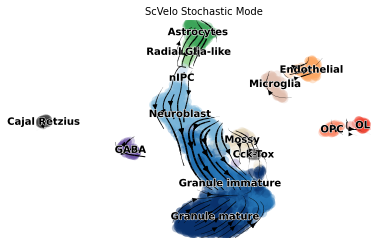

# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.5085378}
Total Mean: 0.5085378289222717
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.8861011346479906}
Total Mean: -0.8861011346479906
# In-cluster Coherence
{'Astrocytes': 0.8558933, 'Cajal Retzius': 0.9876432, 'Cck-Tox': 0.9481789, 'Endothelial': 0.9474042, 'GABA': 0.90869683, 'Granule immature': 0.8450072, 'Granule mature': 0.80969536, 'Microglia': 0.9754837, 'Mossy': 0.89986753, 'Neuroblast': 0.9308812, 'OL': 0.9506476, 'OPC': 0.92203844, 'Radial Glia-like': 0.89049774, 'nIPC': 0.94443244}
Total Mean: 0.9154548048973083
# In-cluster Confidence
{'Astrocytes': 0.892010415593783, 'Cajal Retzius': 0.9845344126224518, 'Cck-Tox': 0.8860587852972525, 'Endothelial': 0.8625854274322247, 'GABA': 0.8818325673947569, 'Granule immature': 0.8406926885531966, 'Granule mature': 0.8008263841967717, 'Microglia': 0.8768389931431523, 'Mossy': 0.

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=k_cluster,
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

Train Epoch: 100/20000 	Loss: 2.996981
Train Epoch: 200/20000 	Loss: 2.828395
Train Epoch: 300/20000 	Loss: 2.490629
Train Epoch: 400/20000 	Loss: 2.082373
Train Epoch: 500/20000 	Loss: 1.729216
Train Epoch: 600/20000 	Loss: 1.481321
Train Epoch: 700/20000 	Loss: 1.321588
Train Epoch: 800/20000 	Loss: 1.219529
Train Epoch: 900/20000 	Loss: 1.137883
Train Epoch: 1000/20000 	Loss: 1.054040
Train Epoch: 1100/20000 	Loss: 0.964798
Train Epoch: 1200/20000 	Loss: 0.873160
Train Epoch: 1300/20000 	Loss: 0.785555
Train Epoch: 1400/20000 	Loss: 0.703610
Train Epoch: 1500/20000 	Loss: 0.629251
Train Epoch: 1600/20000 	Loss: 0.560275
Train Epoch: 1700/20000 	Loss: 0.499803
Train Epoch: 1800/20000 	Loss: 0.448666
Train Epoch: 1900/20000 	Loss: 0.407339
Train Epoch: 2000/20000 	Loss: 0.373602
Train Epoch: 2100/20000 	Loss: 0.344976
Train Epoch: 2200/20000 	Loss: 0.319626
Train Epoch: 2300/20000 	Loss: 0.296206
Train Epoch: 2400/20000 	Loss: 0.274721
Train Epoch: 2500/20000 	Loss: 0.255309
Train Epo

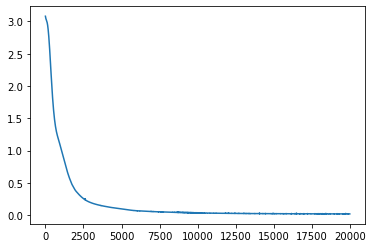

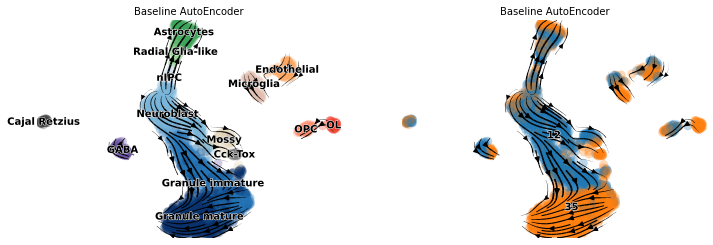

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.95505536}
Total Mean: 0.9550553560256958
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.4936568700862689}
Total Mean: -0.4936568700862689
# In-cluster Coherence
{'Astrocytes': 0.99748915, 'Cajal Retzius': 0.9996991, 'Cck-Tox': 0.9989392, 'Endothelial': 0.9945491, 'GABA': 0.9983604, 'Granule immature': 0.9990189, 'Granule mature': 0.99864423, 'Microglia': 0.9978386, 'Mossy': 0.9968054, 'Neuroblast': 0.997982, 'OL': 0.99948335, 'OPC': 0.9991796, 'Radial Glia-like': 0.99742866, 'nIPC': 0.99747545}
Total Mean: 0.998063862323761
# In-cluster Confidence
{'Astrocytes': 0.9970781033237776, 'Cajal Retzius': 0.9994286982452169, 'Cck-Tox': 0.9959155740561308, 'Endothelial': 0.9932302668176848, 

In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    
    model = get_baseline_AE(in_dim, z_dim, h_dim).to(device)
    model = main_AE(args, model, save_name=f"baseAE_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['clusters', 'age(days)'],
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 2.996022
Train Epoch: 200/20000 	Loss: 2.871044
Train Epoch: 300/20000 	Loss: 2.651240
Train Epoch: 400/20000 	Loss: 2.308442
Train Epoch: 500/20000 	Loss: 1.900359
Train Epoch: 600/20000 	Loss: 1.546579
Train Epoch: 700/20000 	Loss: 1.319961
Train Epoch: 800/20000 	Loss: 1.207196
Train Epoch: 900/20000 	Loss: 1.149200
Train Epoch: 1000/20000 	Loss: 1.102237
Train Epoch: 1100/20000 	Loss: 1.044331
Train Epoch: 1200/20000 	Loss: 0.963353
Train Epoch: 1300/20000 	Loss: 0.857641
Train Epoch: 1400/20000 	Loss: 0.750122
Train Epoch: 1500/20000 	Loss: 0.676048
Train Epoch: 1600/20000 	Loss: 0.638444
Train Epoch: 1700/20000 	Loss: 0.619646
Train Epoch: 1800/20000 	Loss: 0.607001
Train Epoch: 

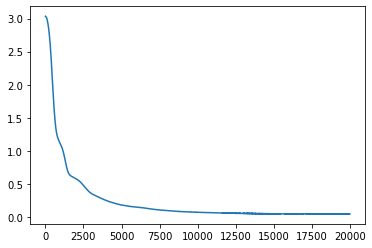

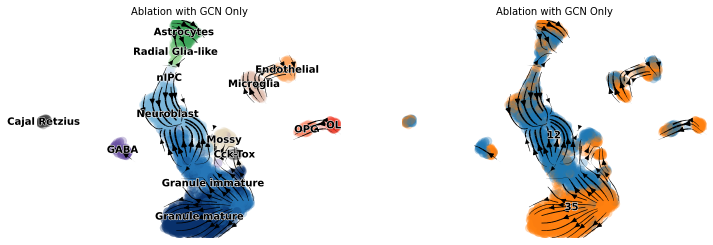

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.99333787}
Total Mean: 0.993337869644165
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.8968565935647332}
Total Mean: -0.8968565935647332
# In-cluster Coherence
{'Astrocytes': 0.9996769, 'Cajal Retzius': 0.9999043, 'Cck-Tox': 0.99962926, 'Endothelial': 0.99828655, 'GABA': 0.9995331, 'Granule immature': 0.99953, 'Granule mature': 0.99947476, 'Microglia': 0.99992293, 'Mossy': 0.99930936, 'Neuroblast': 0.9993314, 'OL': 0.9999147, 'OPC': 0.99984825, 'Radial Glia-like': 0.9978753, 'nIPC': 0.9989683}
Total Mean: 0.9993718266487122
# In-cluster Confidence
{'Astrocytes': 0.9994914948940277, 'Cajal Retzius': 0.9998413394479191, 'Cck-Tox': 0.998449151162748, 'Endothelial': 0.9980362866116667, '

In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    g_basis = args.nb_g_src
    model = get_ablation_CohAgg(
                                adata,
                                in_dim,
                                z_dim,
                                h_dim,
                                g_basis,
                                device)
    model = main_AE(args, model, save_name=f"CohAgg_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['clusters', 'age(days)'],
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

Train Epoch: 100/20000 	Loss: 2.851781
Train Epoch: 200/20000 	Loss: 2.166994
Train Epoch: 300/20000 	Loss: 1.865305
Train Epoch: 400/20000 	Loss: 1.715763
Train Epoch: 500/20000 	Loss: 1.636948
Train Epoch: 600/20000 	Loss: 1.571090
Train Epoch: 700/20000 	Loss: 1.520969
Train Epoch: 800/20000 	Loss: 1.478545
Train Epoch: 900/20000 	Loss: 1.445162
Train Epoch: 1000/20000 	Loss: 1.410237
Train Epoch: 1100/20000 	Loss: 1.384179
Train Epoch: 1200/20000 	Loss: 1.359258
Train Epoch: 1300/20000 	Loss: 1.337890
Train Epoch: 1400/20000 	Loss: 1.341280
Train Epoch: 1500/20000 	Loss: 1.336075
Train Epoch: 1600/20000 	Loss: 1.318899
Train Epoch: 1700/20000 	Loss: 1.315423
Train Epoch: 1800/20000 	Loss: 1.304680
Train Epoch: 1900/20000 	Loss: 1.296782
Train Epoch: 2000/20000 	Loss: 1.289628
Train Epoch: 2100/20000 	Loss: 1.282880
Train Epoch: 2200/20000 	Loss: 1.277794
Train Epoch: 2300/20000 	Loss: 1.272689
Train Epoch: 2400/20000 	Loss: 1.272081
Train Epoch: 2500/20000 	Loss: 1.268006
Train Epo

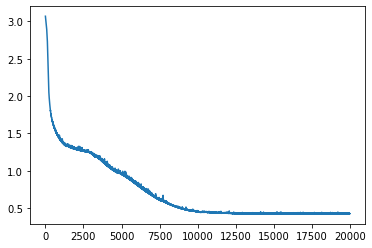

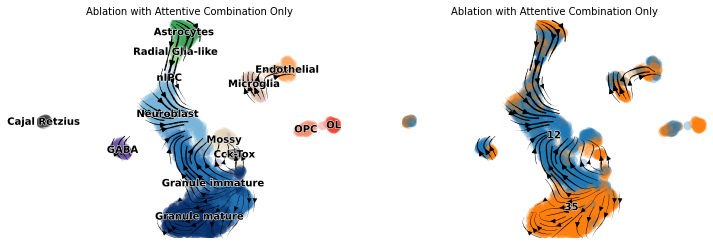

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.027470723}
Total Mean: 0.027470722794532776
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.9932407}
Total Mean: 0.9932407140731812
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): 0.9539566691502819}
Total Mean: 0.9539566691502819
# In-cluster Coherence
{'Astrocytes': 0.9996615, 'Cajal Retzius': 0.9989449, 'Cck-Tox': 0.999158, 'Endothelial': 0.99749434, 'GABA': 0.9987386, 'Granule immature': 0.9981245, 'Granule mature': 0.9972428, 'Microglia': 0.99902034, 'Mossy': 0.99601674, 'Neuroblast': 0.9983683, 'OL': 0.99965525, 'OPC': 0.99902755, 'Radial Glia-like': 0.99887705, 'nIPC': 0.9985998}
Total Mean: 0.9984949827194214
# In-cluster Confidence
{'Astrocytes': 0.9995692044496536, 'Cajal Retzius': 0.9990359983023476, 'Cck-Tox': 0.9963624918902362, 'Endothelia

In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    gb_tau = args.gumbsoft_tau
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        gb_tau,
        device)
    
            
    model = main_AE(args, model, save_name=f"AttComb_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['clusters', 'age(days)'],
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


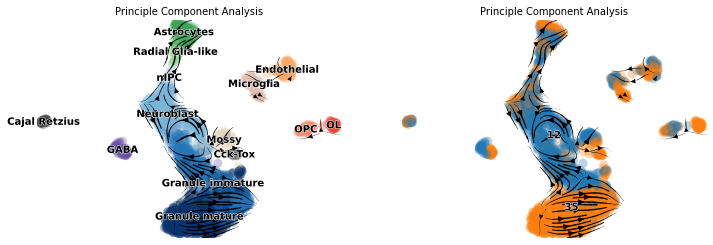

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.38795054}
Total Mean: 0.3879505395889282
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.8177777194621964}
Total Mean: -0.8177777194621964
# In-cluster Coherence
{'Astrocytes': 0.8153231, 'Cajal Retzius': 0.95745546, 'Cck-Tox': 0.91315264, 'Endothelial': 0.53113085, 'GABA': 0.90321064, 'Granule immature': 0.6450038, 'Granule mature': 0.56135917, 'Microglia': 0.76473063, 'Mossy': 0.7786037, 'Neuroblast': 0.76987135, 'OL': 0.85099846, 'OPC': 0.92421436, 'Radial Glia-like': 0.68023133, 'nIPC': 0.9776758}
Total Mean: 0.7909258008003235
# In-cluster Confidence
{'Astrocytes': 0.7990381600956122, 'Cajal Retzius': 0.9545292819247526, 'Cck-Tox': 0.7530966174823267, 'Endothelial': 0.51061672331

In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['clusters', 'age(days)'],
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expPCA(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


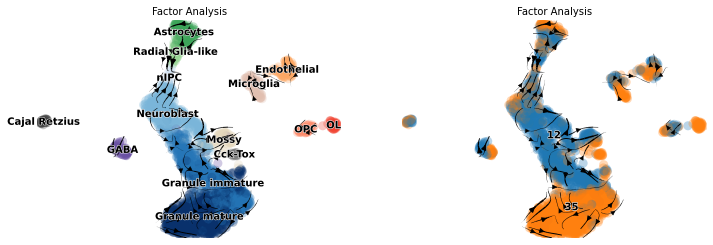

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.22896589446786392}
Total Mean: 0.22896589446786392
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): 0.6714550742665566}
Total Mean: 0.6714550742665566
# In-cluster Coherence
{'Astrocytes': 0.6278206016774719, 'Cajal Retzius': 0.9907785313439057, 'Cck-Tox': 0.9784818653916616, 'Endothelial': 0.38549201334022115, 'GABA': 0.7815308133966632, 'Granule immature': 0.7009455916751118, 'Granule mature': 0.567745440920853, 'Microglia': 0.640366312493162, 'Mossy': 0.8747811494764267, 'Neuroblast': 0.7287681230176006, 'OL': 0.6053868501204949, 'OPC': 0.7099218565804823, 'Radial Glia-like': 0.7304199223822376, 'nIPC': 0.9420303706387397}
Total Mean: 0.7331763887467879
# In-cluster Confidence
{'Astroc

In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['clusters', 'age(days)'],
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expFA(adata, exp_metrics)

In [14]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)